In [1]:
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Interfacing with SfePy

This example recreates one of the SfePy examples using data generated with Nanomesh.

The example is based on:
https://sfepy.org/doc-devel/examples/diffusion-laplace_fluid_2d.html

### Clean up old files

In [2]:
from pathlib import Path

for fn in ('phi_citroen.vtk', 'regions.vtk', 'citroen.msh'):
    try:
        Path(fn).unlink()
    except:
        pass
    else:
        print(f'{fn} deleted')

phi_citroen.vtk deleted
citroen.msh deleted


### Generate mesh data

In [3]:
from sfepy import data_dir
import subprocess as sp

sp.run(f'gmsh -2 -f msh22 {data_dir}\\meshes\\2d\\citroen.geo -o citroen.msh')

CompletedProcess(args='gmsh -2 -f msh22 C:\\Users\\Stef\\python\\sfepy\\meshes\\2d\\citroen.geo -o citroen.msh', returncode=0)

### Loading the data with Nanomesh

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<AxesSubplot:title={'center':'triangle mesh'}>

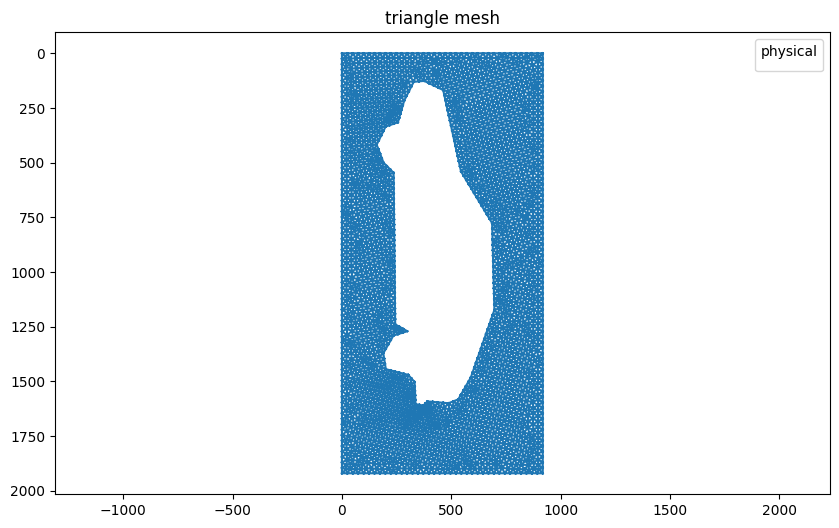

In [4]:
from nanomesh import MeshContainer

nanomesh_mesh = MeshContainer.read('citroen.msh')
nanomesh_mesh.plot()

### Set up sfepy config

Noe that the mesh hook uses the mesh container loaded using Nanomesh.

In [5]:
from sfepy.discrete.fem.meshio import UserMeshIO
from sfepy.discrete.fem import Mesh
import numpy as np

def mesh_hook(mesh, mode):
    if mode == 'read':
        coors = nanomesh_mesh.points
        conn = nanomesh_mesh.get('triangle').cells
        mat_ids = nanomesh_mesh.get('triangle').cell_data['geometrical']
        descs = ['2_3']

        mesh = Mesh.from_data('triangle', coors, None,
                                      [conn], [mat_ids], descs)
        return mesh
    elif mode == 'write':
        pass


class mod:
    __file__ = 'nanomesh'  # dummy value
    filename_mesh = UserMeshIO(mesh_hook)

    v0 = np.array([1, 0.25])

    materials = {
        'm': ({'v0': v0.reshape(-1, 1)},),
    }

    regions = {
        'Omega': 'all',
        'Gamma_Left': ('vertices in (x < 0.1)', 'facet'),
        'Gamma_Right': ('vertices in (x > 1919.9)', 'facet'),
        'Gamma_Top': ('vertices in (y > 917.9)', 'facet'),
        'Gamma_Bottom': ('vertices in (y < 0.1)', 'facet'),
        'Vertex': ('vertex in r.Gamma_Left', 'vertex'),
    }

    fields = {
        'u': ('real', 1, 'Omega', 1),
    }

    variables = {
        'phi': ('unknown field', 'u', 0),
        'psi': ('test field', 'u', 'phi'),
    }

    # these EBCS prevent the matrix from being singular, see description
    ebcs = {
        'fix': ('Vertex', {'phi.0': 0.0}),
    }

    integrals = {
        'i': 2,
    }

    equations = {
        'Laplace equation':
            """dw_laplace.i.Omega( psi, phi )
             = dw_surface_ndot.i.Gamma_Left( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Right( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Top( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Bottom( m.v0, psi )"""
    }

    solvers = {
        'ls': ('ls.scipy_direct', {}),
        'newton': ('nls.newton', {
            'i_max': 1,
            'eps_a': 1e-10,
        }),
    }

from sfepy.base.conf import ProblemConf

conf = ProblemConf.from_module(mod)

sfepy: left over: ['__module__', '__file__', 'filename_mesh', 'v0', 'materials', 'regions', 'fields', 'variables', 'ebcs', 'integrals', 'equations', 'solvers', '__dict__', '__weakref__', '__doc__', 'verbose', '_filename']


In [6]:
from sfepy.discrete.fem import Mesh
trunk = conf.filename_mesh.get_filename_trunk()
_ = Mesh(trunk)
mesh = conf.filename_mesh.read(_)
# mesh = io.read(mesh, omit_facets=omit_facets)
mesh._set_shape_info()

### Solving the PDE with FEM

In [7]:
from sfepy.applications import solve_pde

problem, variables = solve_pde(conf)

sfepy: reading mesh (triangle)...
sfepy: ...done in 0.00 s
sfepy: warning: bad element orientation, trying to correct...
sfepy: ...corrected
sfepy: creating regions...
sfepy:     Omega
sfepy:     Gamma_Left
sfepy:     Gamma_Right
sfepy:     Gamma_Top
sfepy:     Gamma_Bottom
sfepy:     Vertex
sfepy: ...done in 0.01 s
sfepy: equation "Laplace equation":
sfepy: dw_laplace.i.Omega( psi, phi )
             = dw_surface_ndot.i.Gamma_Left( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Right( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Top( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Bottom( m.v0, psi )
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (2783, 2783)
sfepy: assembling matrix graph...
sfepy: ...done in 0.00 s
sfepy: matrix structural nonzeros: 18713 (2.42e-01% fill)
sfepy: updating vari

### Plot with Mayavi

Note that this will open a new window.

In [8]:
from sfepy.postprocess.viewer import Viewer

problem.save_state('phi_citroen.vtk', variables)

view = Viewer('phi_citroen.vtk')
view(rel_scaling=2, is_scalar_bar=True,
     is_wireframe=True, colormap='viridis')

sfepy: reading mesh (phi_citroen.vtk)...
sfepy:   number of vertices: 2784
sfepy:   number of cells:
sfepy:     2_3: 5184
sfepy: ...done in 0.01 s
sfepy: point scalars phi at [-960. -459.    0.]
sfepy: range: 0.00e+00 3.58e+03 l2 norm range: 0.00e+00 3.58e+03


### Re-create plot from examples using pyvista

mesh from phi_citroen.vtk:
  points:  2784
  cells:   5184
  bounds:  [(0.0, 1920.0), (0.0, 918.0), (0.0, 0.0)]
  scalars: phi, node_groups, mat_id
  steps:   1


C:\Users\Stef\miniconda3\envs\nanomesh\lib\site-packages\pyvista\core\pointset.py:201: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


plot 0: phi(step 0); phi(step 0)


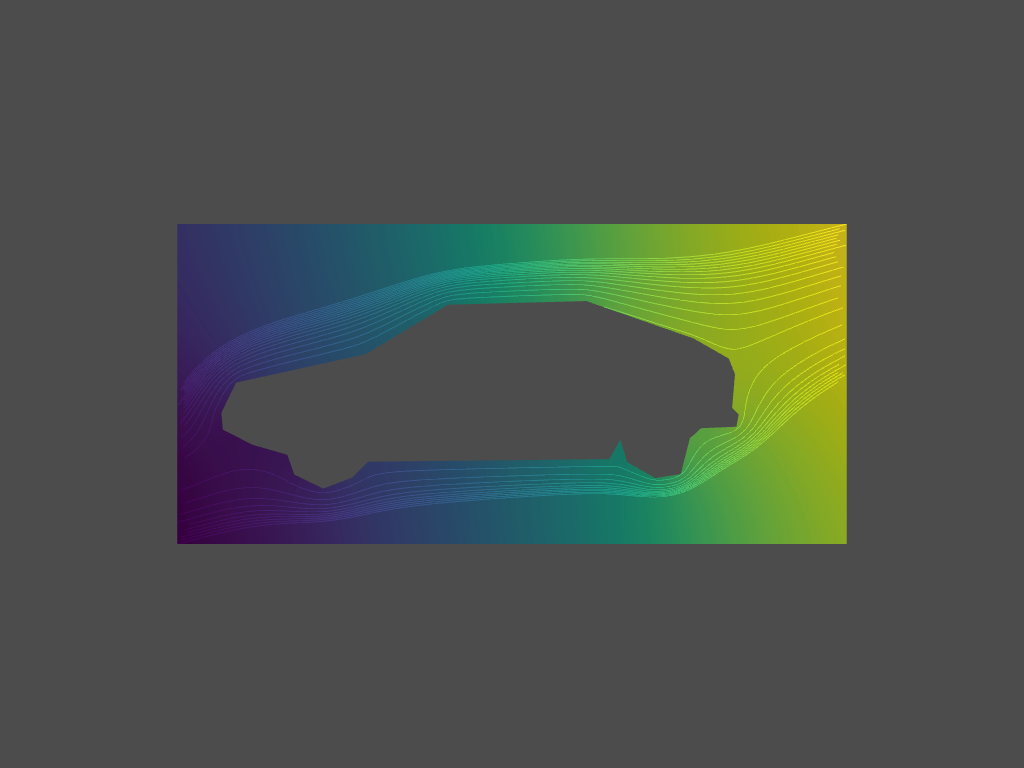

In [9]:
from resview import pv_plot

class options:
    step = 0
    view_2d = True
    position_vector = None
    fields_map = []
    fields = [
        ('phi', 'p0'),
        ('phi', 't50:p0'),
             ]
    opacity = 1.
    show_edges = False
    warp = None
    factor = 1.0
    outline = False
    color_map = None
    show_scalar_bars = False
    show_labels = False

import pyvista as pv

plotter = pv.Plotter()
plotter = pv_plot(['phi_citroen.vtk'], options=options, plotter=plotter)
plotter.view_xy()
plotter.show(jupyter_backend='static')